In [2]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import os
import copy
from copy import deepcopy
import gymnasium as gym
from matplotlib.animation import FuncAnimation
from collections import deque
from IPython.display import clear_output
from config import config

# import os
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

import matplotlib.pyplot as plt

import gymnasium as gym
import highway_env

In [14]:
config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 3,
    "vehicles_count": 10,
    "duration": 20,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env = gym.make("highway-v0",render_mode='rgb_array')



env.unwrapped.configure(config)

In [17]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)


class Net(nn.Module):
    """
    Basic neural net.
    """

    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        x = x.reshape(-1,1)
        m = len(x)
        m = m - m%5
        x = x[:m]
        x = x.reshape(-1,5)
        x = self.net(x)
        return x

In [39]:
class DQN:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space

        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):

        # add data to replay buffer
        self.buffer.push(
            torch.tensor(state).unsqueeze(0),
            torch.tensor([[action]], dtype=torch.int64),
            torch.tensor([reward]),
            torch.tensor([terminated], dtype=torch.int64),
            torch.tensor(next_state).unsqueeze(0),
        )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        (
            state_batch,
            action_batch,
            reward_batch,
            terminated_batch,
            next_state_batch,
        ) = tuple([torch.cat(data) for data in zip(*transitions)])

        values = self.q_net.forward(state_batch).gather(0, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0][:64]
            targets = next_state_values * self.gamma + reward_batch
        targets = targets.float()
        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated or reward==0:
            self.n_eps += 1
            

        return loss.detach().numpy()

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate
        )

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0
    
    def save(self, filename):
        torch.save({
            'q_net_state_dict': self.q_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'steps': self.n_steps,
            'eps': self.n_eps,
            'epsilon': self.epsilon,}, filename)
        
    def load(self, filename):
        checkpoint = torch.load(filename)
        self.q_net.load_state_dict(checkpoint['q_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.n_steps = checkpoint['steps']
        self.n_eps = checkpoint['eps']
        self.epsilon = checkpoint['epsilon']


Episode 1/10, Reward: 18.70740567844437
Episode 2/10, Reward: 18.214488234520598
Episode 3/10, Reward: 3.3077714865320402
Episode 4/10, Reward: 4.245260851194919
Episode 5/10, Reward: 13.155442873649493
Episode 6/10, Reward: 2.9059684432766497
Episode 7/10, Reward: 3.838901503120794
Episode 8/10, Reward: 14.026070401494312
Episode 9/10, Reward: 3.7496981074177764
Episode 10/10, Reward: 35.78497152934381


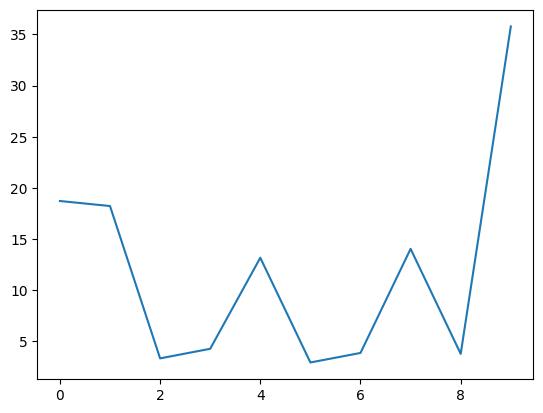

In [48]:
env = gym.make("highway-v0",render_mode='rgb_array')



env.unwrapped.configure(config)

agent = DQN(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    batch_size=64,
    buffer_capacity=10000,
    update_target_every=1000,
    epsilon_start=0.8,
    decrease_epsilon_factor=200,
    epsilon_min=0.01,
    learning_rate=0.001,
)

# Définissez le nombre total d'épisodes d'entraînement
total_episodes = 10
# Définissez le nombre maximal d'étapes par épisode
max_steps_per_episode = 300

# Boucle d'apprentissage
P=[]
for episode in range(total_episodes):
    state, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        # Choisissez une action en fonction de l'état actuel
        action = agent.get_action(state)
        
        # Effectuez l'action dans l'environnement
        next_state, reward, done, _, info = env.step(action)

        # Mettez à jour l'agent et obtenez la perte (si applicable)
        loss = agent.update(state, action, reward, done, next_state)
        
        episode_reward += reward
        state = next_state

        if done:
            break
    P.append(episode_reward)
    #env.render()

    # Affichez la récompense totale de l'épisode
    print(f"Episode {episode+1}/{total_episodes}, Reward: {episode_reward}")
plt.plot(P)
plt.show()

Episode 1/100, Reward: 7.464010663935722
Episode 2/100, Reward: 33.49430058732964
Episode 3/100, Reward: 28.406187059783623
Episode 4/100, Reward: 8.718126102192015
Episode 5/100, Reward: 8.463457094525245
Episode 6/100, Reward: 4.749718272777676
Episode 7/100, Reward: 10.582104234474452
Episode 8/100, Reward: 1.3432080771901302
Episode 9/100, Reward: 2.655528333904
Episode 10/100, Reward: 12.682062244811645
Episode 11/100, Reward: 5.905666187278914
Episode 12/100, Reward: 3.5574008065495493
Episode 13/100, Reward: 4.530948321028611
Episode 14/100, Reward: 15.738520476442288
Episode 15/100, Reward: 2.280812623838583
Episode 16/100, Reward: 13.999068097083727
Episode 17/100, Reward: 12.307541892028675
Episode 18/100, Reward: 6.4012797021736505
Episode 19/100, Reward: 29.463739679398767
Episode 20/100, Reward: 4.593604049091663
Episode 21/100, Reward: 0.9014845383128791
Episode 22/100, Reward: 7.807328906657188
Episode 23/100, Reward: 10.941731234643548
Episode 24/100, Reward: 7.62434761

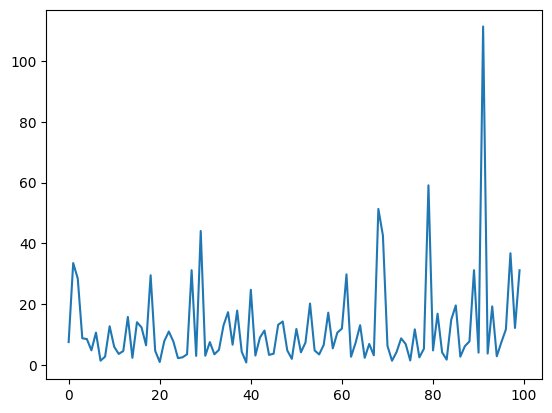

In [49]:
env = gym.make("highway-v0",render_mode='rgb_array')



env.unwrapped.configure(config)

agent = DQN(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    batch_size=64,
    buffer_capacity=10000,
    update_target_every=1000,
    epsilon_start=0.6,
    decrease_epsilon_factor=200,
    epsilon_min=0.01,
    learning_rate=0.1,
)

# Définissez le nombre total d'épisodes d'entraînement
total_episodes =100
# Définissez le nombre maximal d'étapes par épisode
max_steps_per_episode = 300
L=[]
P=[]
# Boucle d'apprentissage
c=0
for episode in range(total_episodes):
    
    state, info = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        # Choisissez une action en fonction de l'état actuel
        action = agent.get_action(state)
        
        # Effectuez l'action dans l'environnement
        next_state, reward, done, truncated, info = env.step(action)

        # Mettez à jour l'agent et obtenez la perte (si applicable)
        loss = agent.update(state, action, reward, done, next_state)
        
        episode_reward += reward
        state = next_state

        if done:
            break
    
    P.append(episode_reward)
    c=c+1
    env.render()

    # Affichez la récompense totale de l'épisode
    print(f"Episode {episode+1}/{total_episodes}, Reward: {episode_reward}")
    agent.save(f"highway_DQN_Model_{episode + 1}")
plt.plot(P)
plt.show()

In [72]:
import imageio

def run_and_record(model_file, episodes=10, steps_per_episode=300):
    # Assurez-vous que la version de gymnasium prend en charge 'render_mode'
    agent.load(model_file)  # Assurez-vous que cette fonction est correctement définie

    for episode in range(episodes):
        state, _ = env.reset()
        frames = []
        for step in range(steps_per_episode):
            action = agent.get_action(state)  # Choisissez toujours l'action la plus optimale
            state, reward, done, _, _ = env.step(action)
            frames.append(env.render())  # Capturez le frame
            if done:
                break

        # Sauvegarder les frames en tant que GIF
        filename = f'result_episode_{episode + 1}.gif'
        imageio.mimsave(filename, frames, fps=30)
        print(f"Vidéo sauvegardée sous {filename}")

# Utilisation de la fonction
run_and_record('highway_DQN_Model_98')

Vidéo sauvegardée sous result_episode_1.gif
Vidéo sauvegardée sous result_episode_2.gif
Vidéo sauvegardée sous result_episode_3.gif
Vidéo sauvegardée sous result_episode_4.gif
Vidéo sauvegardée sous result_episode_5.gif
Vidéo sauvegardée sous result_episode_6.gif
Vidéo sauvegardée sous result_episode_7.gif
Vidéo sauvegardée sous result_episode_8.gif
Vidéo sauvegardée sous result_episode_9.gif
Vidéo sauvegardée sous result_episode_10.gif
